# Predicting housing prices in Poland
---

## Introduction

This project aims to make a machine learning model that can predict with a +90% accuracy the price of a house in Poland between August 2023 and June 2024

## About the dataset
The dataset contains apartment sales and rent offers from the 15 largest cities in Poland (Warsaw, Lodz, Krakow, Wroclaw, Poznan, Gdansk, Szczecin, Bydgoszcz, Lublin, Katowice, Bialystok, Czestochowa). The data comes from local websites with apartments for sale. To fully capture the neighborhood of each apartment better, each offer was extended by data from the Open Street Map with distances to points of interest (POI)

[**Link for the dataset**](https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland)

## The Project

### 1. Loading and Understanding the Data

First we import all the necessary libraries

In [43]:
# Importing libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MultipleLocator
from time import time

We then load the dataset by reading all the CSV files

In [44]:
folder_path = "./data"
csv_files = glob.glob(os.path.join(folder_path, 'apartments*.csv'))

df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)
df.drop(columns='id', axis=1, inplace=True)

---

### 2. Understanding and cleaning the data

#### Dataset Overview
- 195568 samples
- 28 different features, all with different types (numerical, binary, etc...)
- Some Missing Values for different features

In [45]:
print ("number of elements in the dataset: " + str(len(df.index)))
df.head()

number of elements in the dataset: 195568


,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,szczecin,apartmentBuilding,105.00,4.0,3.0,4.0,2016.0,53.431503,14.485820,5.06,...,0.335,condominium,brick,premium,no,yes,yes,no,no,1199999
1,szczecin,tenement,73.02,3.0,2.0,3.0,NaN,53.452222,14.553333,3.24,...,0.280,condominium,brick,NaN,no,no,no,no,no,650000
2,szczecin,blockOfFlats,68.61,3.0,4.0,4.0,1997.0,53.456213,14.583222,3.94,...,0.304,condominium,brick,NaN,no,yes,no,no,yes,590000
3,szczecin,blockOfFlats,42.00,2.0,1.0,3.0,NaN,53.468056,14.538333,5.19,...,0.257,condominium,NaN,NaN,no,yes,no,no,no,584999
4,szczecin,blockOfFlats,45.50,2.0,4.0,4.0,1960.0,53.438165,14.563200,1.65,...,0.273,condominium,concreteSlab,low,no,no,no,no,yes,363000


#### Feature Description

- **id**:              ID of the entry in the dataset

- **city**:            The city where the place is

- **type**:            Type of the residence, whether it's an apartment building, tenement, or block of flats

- **squareMeters**:   The size of the place

- **rooms**:           Number of rooms

- **floor**:           What floor is the place on if it's an apartment for example

- **floorCount**:     Total nuymber of floors

- **buildYear**:      The year when the place was built

- **latitude**:        Latitude coordinates

- **longitude**:      Longitude coordinates

- **centreDistance** - distance from the city centre in km

- **poiCount** - number of points of interest in 500m range from the apartment (schools, clinics, post offices, kindergartens, restaurants, colleges, pharmacies)

- **[poiName]Distance** - distance to the nearest point of interest (schools, clinics, post offices, kindergartens, restaurants, colleges, pharmacies)

- **ownership** - the type of property ownership

- **condition** - the condition of the apartment

- **has[features]** - whether the property has key features such as assigned parking space, balcony, elevator, security, storage room

- **price** - offer price in Polish Zloty

In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
squareMeters,195568.0,58.697667,21.407206,25.000000,44.000000,54.600000,68.550000,1.500000e+02
rooms,195568.0,2.679222,0.915024,1.000000,2.000000,3.000000,3.000000,6.000000e+00
floor,160974.0,3.332414,2.531684,1.000000,2.000000,3.000000,4.000000,2.900000e+01
floorCount,193185.0,5.309113,3.312234,1.000000,3.000000,4.000000,6.000000,2.900000e+01
buildYear,163352.0,1985.976346,33.812810,1850.000000,1967.000000,1994.000000,2016.000000,2.024000e+03
latitude,195568.0,52.026288,1.335275,49.978999,51.108796,52.194596,52.409006,5.460646e+01
longitude,195568.0,19.465989,1.783264,14.447100,18.523270,19.899434,20.989907,2.320887e+01
centreDistance,195568.0,4.351114,2.835764,0.010000,2.010000,3.980000,6.150000,1.694000e+01
poiCount,195568.0,20.672037,24.325708,0.000000,7.000000,14.000000,24.000000,2.120000e+02
schoolDistance,195400.0,0.412651,0.464193,0.002000,0.176000,0.290000,0.468000,4.946000e+00


#### Removing NaN

Before doing anything we need to remove any row that has NaN for any of the features

In [47]:
df.dropna(inplace=True)

#### Dealing with categorical data

Since some of this data isn't numerical such as the city name, we need to convert this data to numbers for it to be understanded by our model and also to be able to represent such data in diagrams.

We can use either one-hot encoding or label encoding so to decide, we'll first output all the unique values in all the categorical columns to make a more informed decision

In [48]:
categorical_columns = [
    'city', 'type', 'ownership', 'condition', 'buildingMaterial',
    'hasElevator', 'hasBalcony', 'hasParkingSpace', 'hasSecurity',
    'hasStorageRoom'  # Add or remove based on your dataset
]

# Loop through them and print unique values and counts
for col in categorical_columns:
    print(f"Unique values and counts for column '{col}':")
    print(df[col].value_counts(dropna=False))  # Include NaNs if needed
    print("-" * 50)

Unique values and counts for column 'city':
city
warszawa       7623
krakow         3830
wroclaw        2958
lodz           1872
szczecin       1751
lublin          909
radom           834
bydgoszcz       784
poznan          641
katowice        629
gdansk          589
bialystok       380
rzeszow         312
gdynia          214
czestochowa     101
Name: count, dtype: int64
--------------------------------------------------
Unique values and counts for column 'type':
type
blockOfFlats         11046
apartmentBuilding     7298
tenement              5083
Name: count, dtype: int64
--------------------------------------------------
Unique values and counts for column 'ownership':
ownership
condominium    19702
cooperative     3717
udział             8
Name: count, dtype: int64
--------------------------------------------------
Unique values and counts for column 'condition':
condition
premium    14310
low         9117
Name: count, dtype: int64
-------------------------------------------------

After analyzing the data, we realize after looking at the data that we can't stick to one type of encoding but we'll use both but on different features

**One hot encoding** will be used for:
- condition
- buildingMaterial
- hasElevator
- hasBalcony
- hasParkingSpace
- hasSecurity
- hasStorageRoom

**Lable encoding** will be used for:
- city
- type
- ownership

In [49]:
label_encode_cols = ['city', 'type', 'ownership']
one_hot_encode_cols = [
    'condition', 'buildingMaterial', 'hasElevator', 'hasBalcony',
    'hasParkingSpace', 'hasSecurity', 'hasStorageRoom'
]

# Make a copy in case we need the original
df_encoded = df.copy()

## Label Encoding
label_encoders = {}

for col in label_encode_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

## One-hot Encoding
df_encoded = pd.get_dummies(df_encoded, columns=one_hot_encode_cols, drop_first=True)

#### Visualisations

We need to understand our data more so we will draw some visualisations to be able to see the relations better and determine important features 

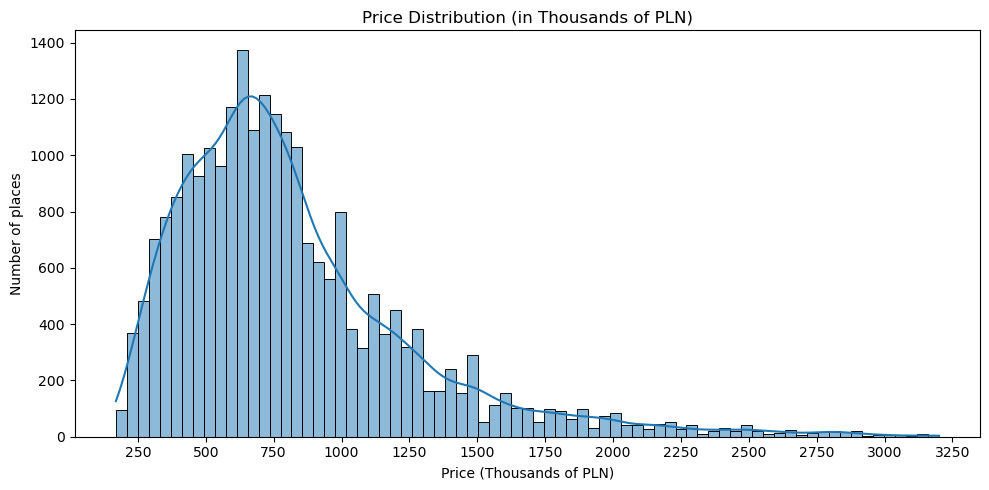

In [50]:
plt.figure(figsize=(10, 5))
sns.histplot(df_encoded['price'] / 1000, bins=75, kde=True)
plt.title('Price Distribution (in Thousands of PLN)')
plt.xlabel('Price (Thousands of PLN)')
plt.ylabel('Number of places')
plt.gca().xaxis.set_major_locator(MultipleLocator(250))
plt.tight_layout()
plt.show()

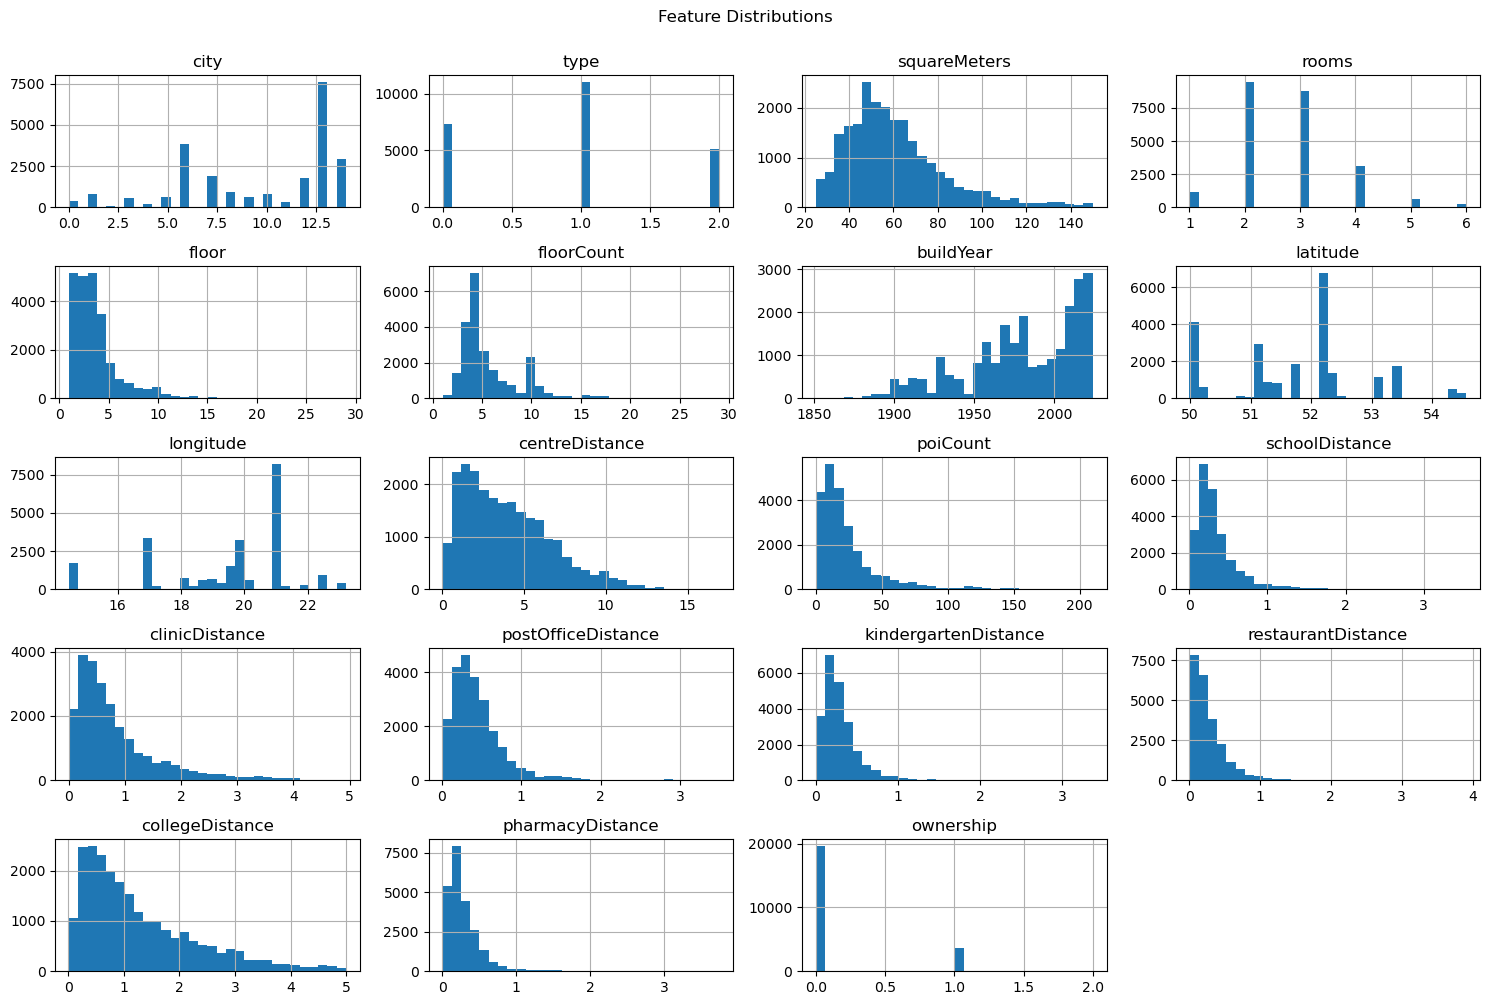

In [51]:
features = df_encoded.columns.drop('price')
df_encoded[features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Feature Distributions', y=1)
plt.tight_layout()
plt.show()

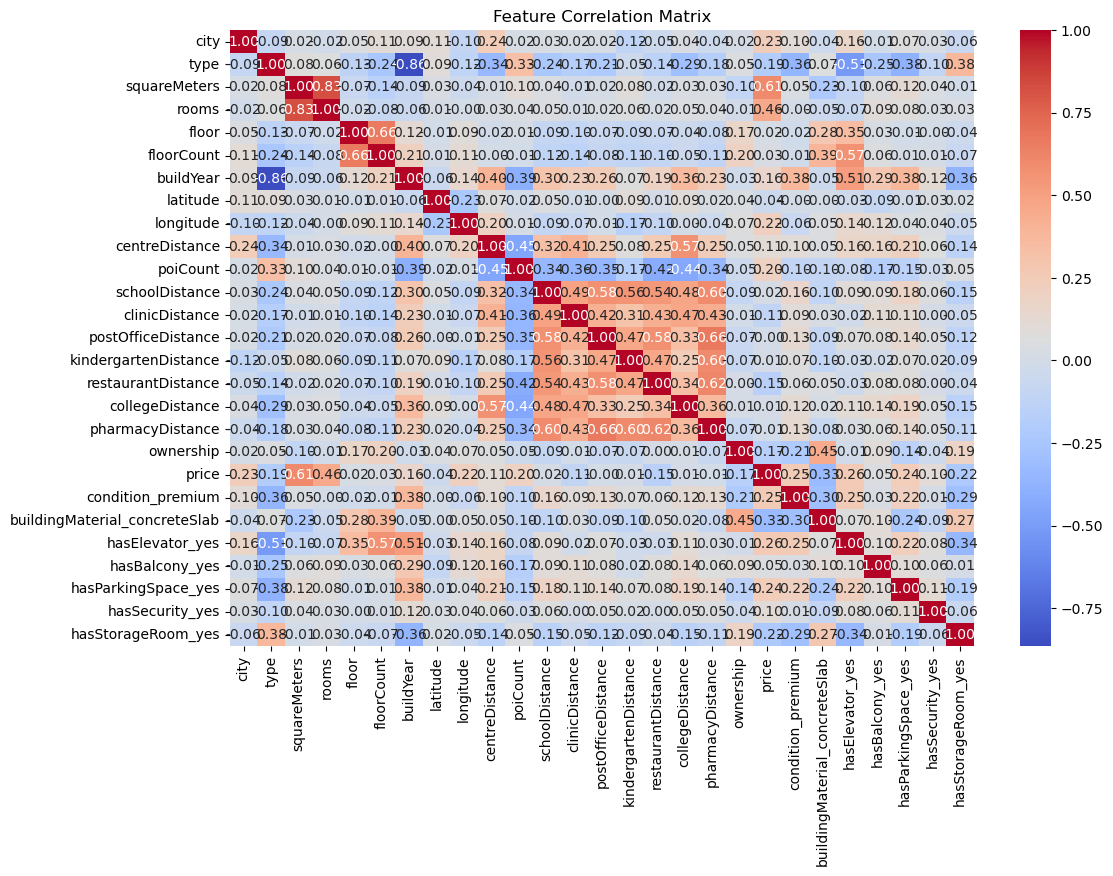

In [52]:
plt.figure(figsize=(12, 8))
corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

#### Looking for outliers and scaling the data

Since a lot of machine learning models are sensitive to outliers and we're trying different models not a specific one, our data needs to be more uniform so we are going to scale it so that the comparison is fair so we start by detecting the outliers

In [ ]:
excluded_cols = ['city', 'type', 'ownership', 'price']
excluded_cols += [col for col in df_encoded.columns if any(prefix in col for prefix in [
    'condition_', 'buildingMaterial_', 'hasElevator_', 'hasBalcony_',
    'hasParkingSpace_', 'hasSecurity_', 'hasStorageRoom_'
])]
cols_to_scale = [col for col in df_encoded.columns if col not in excluded_cols]

df_cleaned = df_encoded.copy()
outlier_indices = set()

for col in cols_to_scale:
    Q1 = df_encoded[col].quantile(0.25)
    Q3 = df_encoded[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.0 * IQR
    upper_bound = Q3 + 1.0 * IQR

    outliers = df_encoded[(df_encoded[col] < lower_bound) | (df_encoded[col] > upper_bound)].index
    outlier_indices.update(outliers)

df_cleaned = df_cleaned.drop(index=outlier_indices)
df_cleaned = df_cleaned.reset_index(drop=True)

Now we split the data 

In [ ]:
X = df_cleaned.drop(columns=['price'])
y = df_cleaned['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

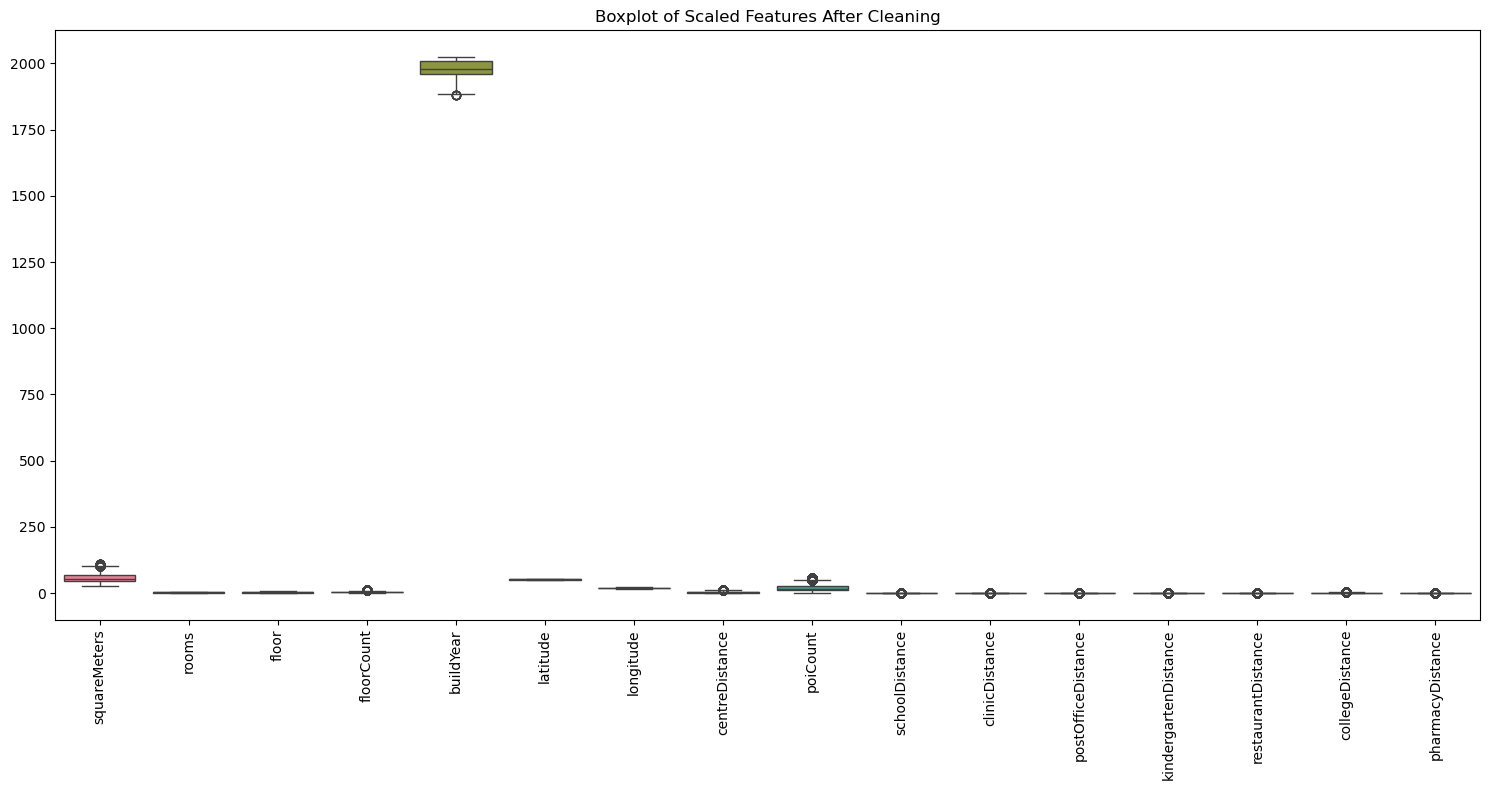

In [70]:
# TEMP

plt.figure(figsize=(15, 8))
sns.boxplot(data=X[cols_to_scale])
plt.xticks(rotation=90)
plt.title("Boxplot of Scaled Features After Cleaning")
plt.tight_layout()
plt.show()

Then we'll scale the values using standard scaler

In [ ]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])


Finally visualise the data to see it better

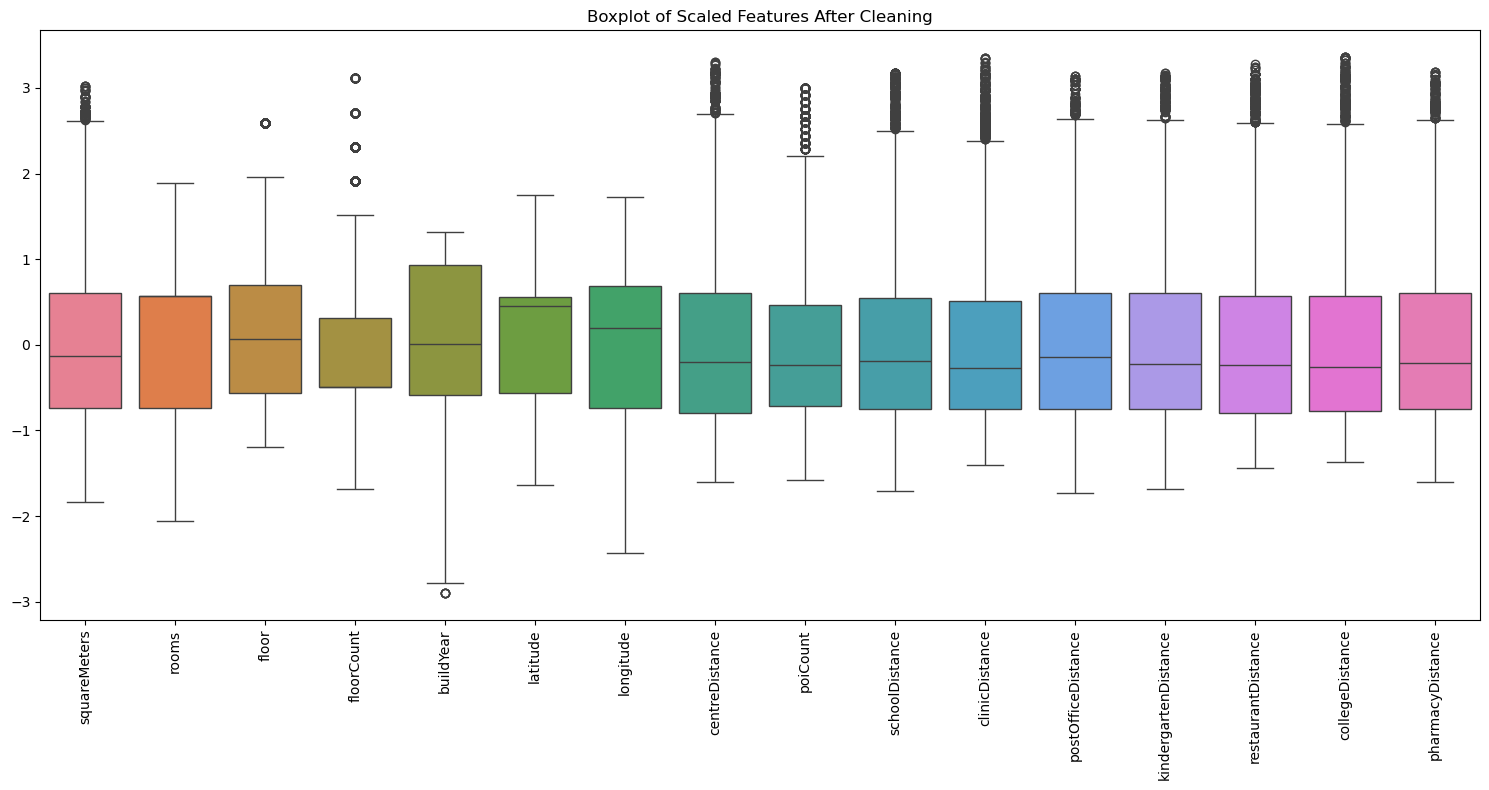

In [71]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=X_train_scaled[cols_to_scale])
plt.xticks(rotation=90)
plt.title("Boxplot of Scaled Features After Cleaning")
plt.tight_layout()
plt.show()